# Homework 7

**Chosen dataset:** Transcriptome Analysis Reveals Non-Foamy Rather Than Foamy Plaque Macrophages Are Proinflammatory in Atherosclerotic Murine Models

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

## Reading the data

First of all, we need to create an AnnData object.

In [2]:
adata = sc.read_10x_mtx(
    'C://Users//Home//GSM3215435_ldlr_ko_//',  
    var_names='gene_symbols',                
    cache=True)     

## Filtering
Now we are going to filter out cells that have less than 200 genes and genes that are present in less than 3 cells.

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Next we will calculate the percentage of mitochondrial genes in cells. Extensive mitochondrial contamination is often present in dying/low-quality cells.

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [5]:
adata.var['mt'].value_counts()

False    14952
True        13
Name: mt, dtype: int64

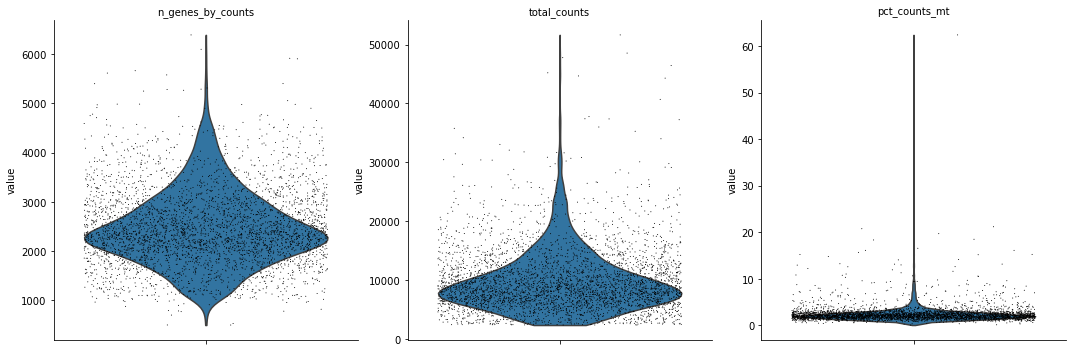

In [6]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

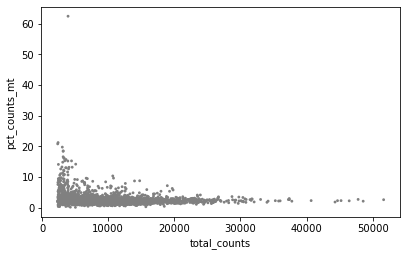

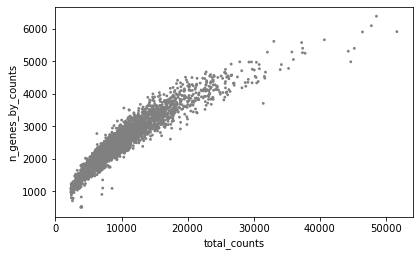

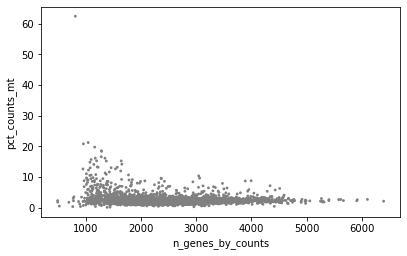

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

As we can see on the plots, we can filter out n_genes_by_counts < 1000 & > 5000 and pct_counts_mt > 5%.

In [8]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.n_genes_by_counts < 5000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

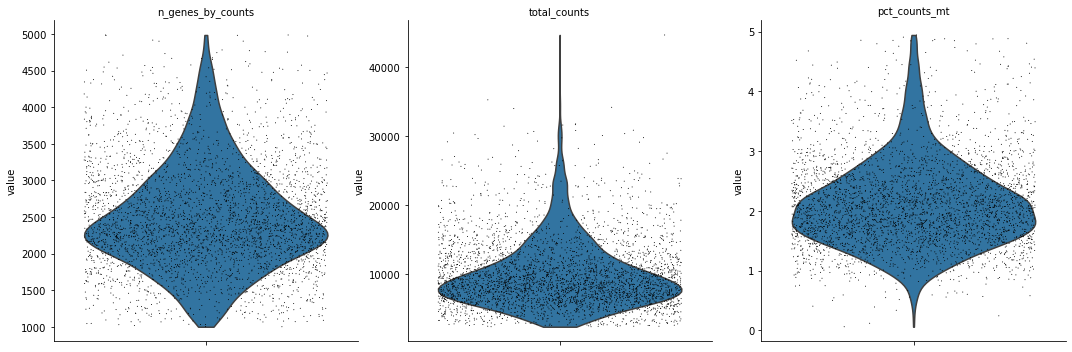

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

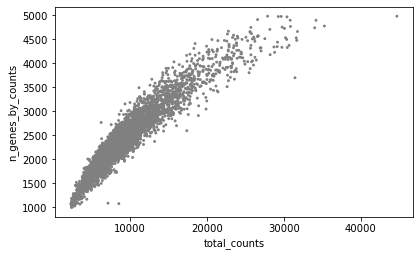

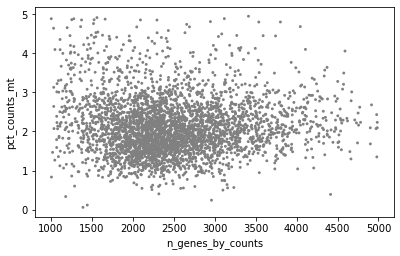

In [10]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

Now plots look good.

## Normalizing and scaling the data

Now we will normalize the data, so that counts become comparable among cells.

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)

Logarithmize the data:

In [12]:
sc.pp.log1p(adata)

In [13]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

0         1    2         3         4         5         6    7    8   \
0   0.799842  0.000000  0.0  0.000000  0.000000  0.000000  0.799842  0.0  0.0   
1   1.437038  0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
2   0.000000  0.000000  0.0  0.791304  0.000000  0.000000  0.000000  0.0  0.0   
3   0.000000  0.000000  0.0  1.040807  0.000000  0.000000  0.000000  0.0  0.0   
4   0.000000  0.000000  0.0  0.000000  1.003190  0.000000  0.000000  0.0  0.0   
..       ...       ...  ...       ...       ...       ...       ...  ...  ...   
95  1.326894  0.000000  0.0  1.326894  0.000000  0.000000  0.000000  0.0  0.0   
96  1.097813  0.000000  0.0  0.000000  0.000000  1.097813  0.000000  0.0  0.0   
97  0.000000  0.000000  0.0  1.231653  0.794550  0.000000  0.000000  0.0  0.0   
98  0.000000  0.390481  0.0  0.889156  0.000000  0.000000  0.000000  0.0  0.0   
99  0.000000  0.539980  0.0  0.000000  1.351675  0.000000  0.000000  0.0  0.0   

     9   ...        90        91   92   93   94        95        96        97  \
0   0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.000000  1.238484  0.000000   
1   0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.000000   
2   0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.000000   
3   0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.000000  1.040807  1.040807   
4   0.0  ...  0.622447  0.622447  0.0  0.0  0.0  0.000000  0.622447  0.000000   
..  ...  ...       ...       ...  ...  ...  ...       ...       ...       ...   
95  0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.000000  0.000000   
96  0.0  ...  0.000000  0.000000  0.0  0.0  0.0  1.097813  1.097813  0.000000   
97  0.0  ...  1.767088  0.000000  0.0  0.0  0.0  0.000000  0.794550  0.000000   
98  0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.000000  0.390481  0.390481   
99  0.0  ...  0.000000  0.000000  0.0  0.0  0.0  0.539980  0.539980  0.888692   

          98   99  
0   1.542351  0.0  
1   0.000000  0.0  
2   1.530139  0.0  
3   0.000000  0.0  
4   1.493788  0.0  
..       ...  ...  
95  1.326894  0.0  
96  1.097813  0.0  
97  0.000000  0.0  
98  1.068417  0.0  
99  0.888692  0.0  

[100 rows x 100 columns]

## Identification of highly variable genes.

Calculating and focusing on a subset of features that exhibit high cell-to-cell variation in the dataset can help to highlight biological signal.

In [14]:
sc.pp.highly_variable_genes(adata,min_mean=0.0125, max_mean=3, min_disp=0.26)

In [15]:
adata.var['highly_variable'].value_counts()

False    13193
True      1772
Name: highly_variable, dtype: int64

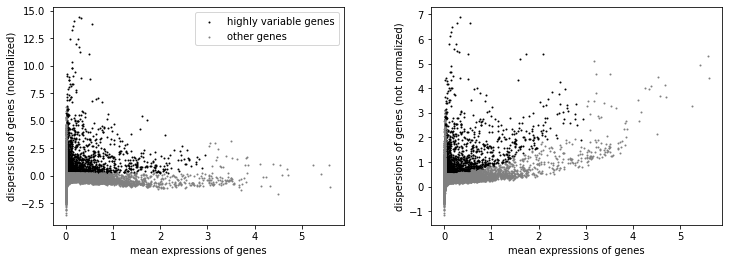

In [16]:
sc.pl.highly_variable_genes(adata)

Flitering highly expressed genes

In [17]:
adata = adata[:, adata.var.highly_variable]

Regressing out the effects of total counts per cell and the percentage of mitochondrial genes expressed.

In [18]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

Scaling each gene to unit variants.

In [19]:
sc.pp.scale(adata, max_value=10)

## PCA

Calculating PCA:

In [20]:
sc.tl.pca(adata, svd_solver='arpack')

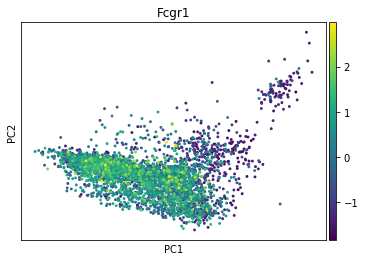

In [21]:
sc.pl.pca(adata, color='Fcgr1')

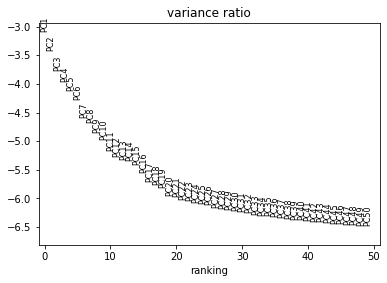

In [22]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

Based on this elbow plot we can take about 30 PCs for further analysis.

## Computing the neighborhood graph

In [23]:
sc.pp.neighbors(adata, n_pcs=30)

## Embedding the neighborhood graph

We are going to use UMAP method.

In [24]:
sc.tl.umap(adata)

## Clustering the neighborhood graph

We are going to use the Leiden graph-clustering method.

In [36]:
sc.tl.louvain(adata, key_added='clusters', resolution=0.6)

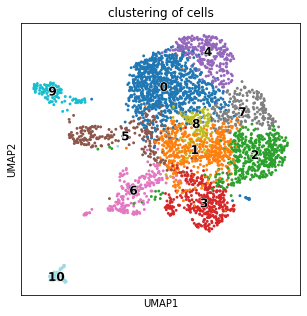

In [37]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(adata, color='clusters',  legend_loc='on data',
               legend_fontsize=12, legend_fontoutline=1,
               title='clustering of cells', palette='tab20')

Let's look at clusters in the related publication. They look kind of similar, but we should look at how cell of these clusters express gene markers in order to see correlation.
Also UMAP method was used instead of t-SNE, which partially explains the difference.

![umap](umap.png)

## Comparison with the publication

Let's look at the expression of principal hematopoietic markers in 11 identified cell clusters.

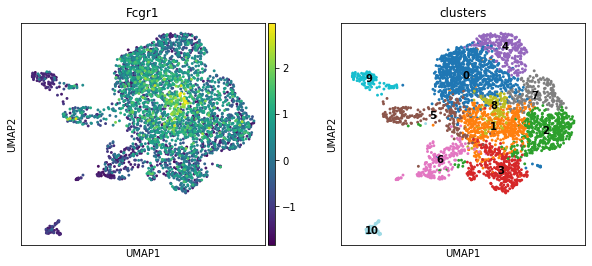

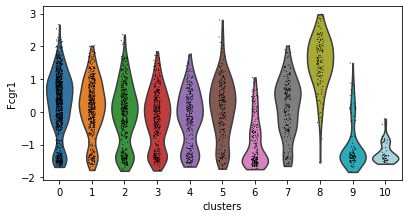

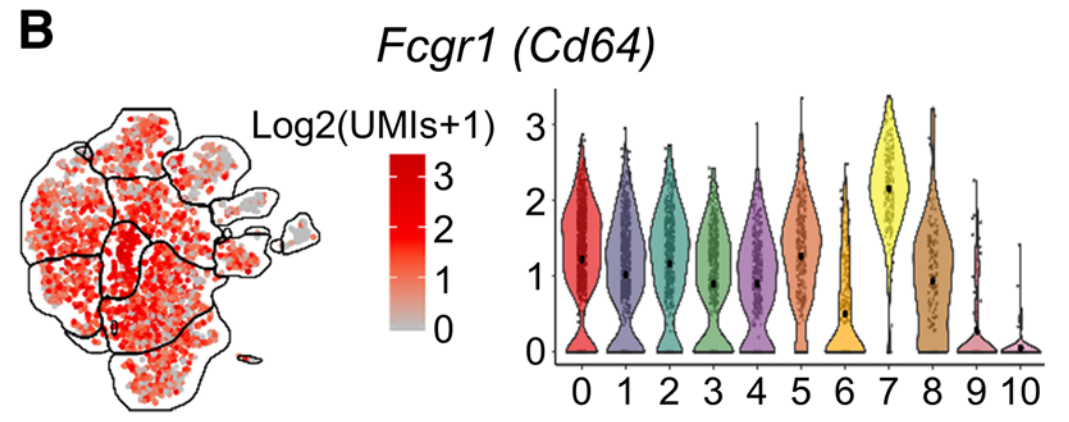

In [38]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Fcgr1", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Fcgr1"], groupby='clusters')
Image(filename='Fcgr1.png')

As we can see the expression of *Fcrg1* (a macrophage marker gene) is very similar between the publication and this analysis. It is highly expressed in 0-5, 7 and and especially 8, which corresponds to the publication.

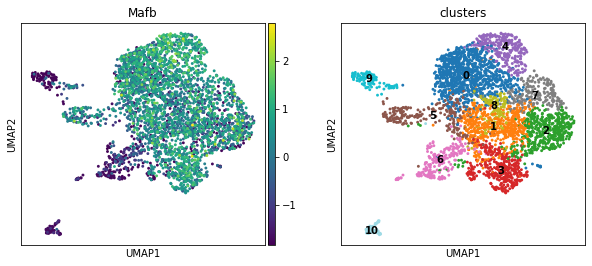

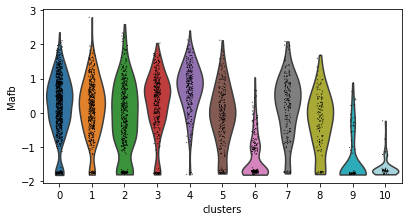

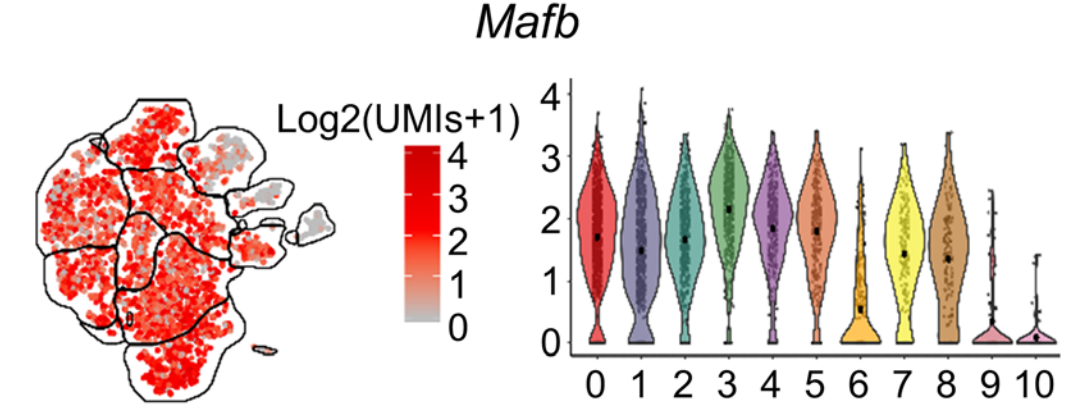

In [39]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Mafb", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Mafb"], groupby='clusters')
Image(filename='Mafb.png')

Another macrophage marker gene *Mafb* is also highly expressed in clusters 0-5, 7 and 8. 

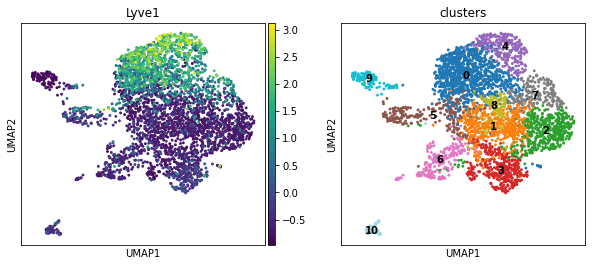

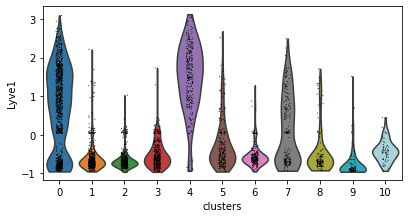

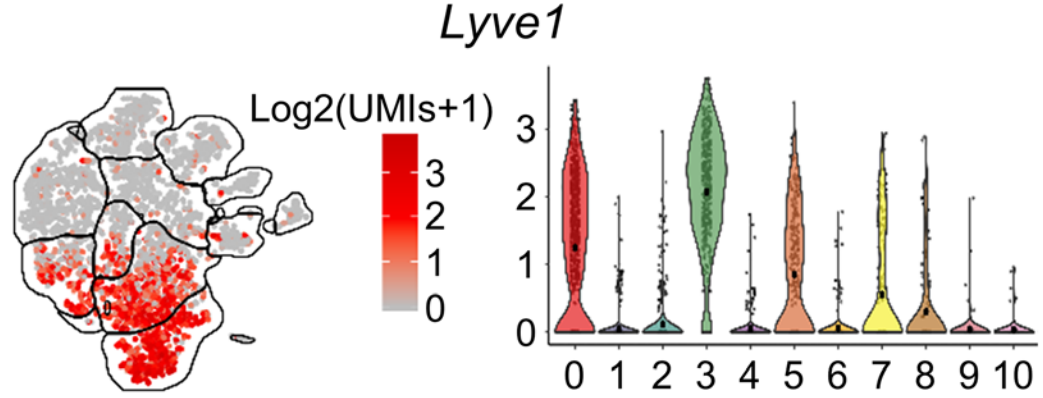

In [40]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Lyve1", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Lyve1"], groupby='clusters')
Image(filename='Lyve1.png')

*Lyve1* is highly expressed in clusters 0, 4 and 7.

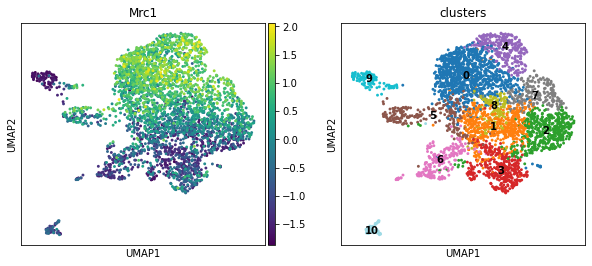

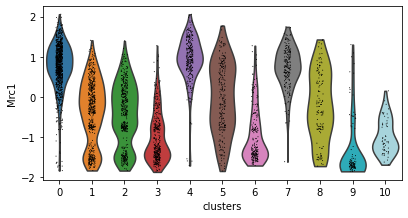

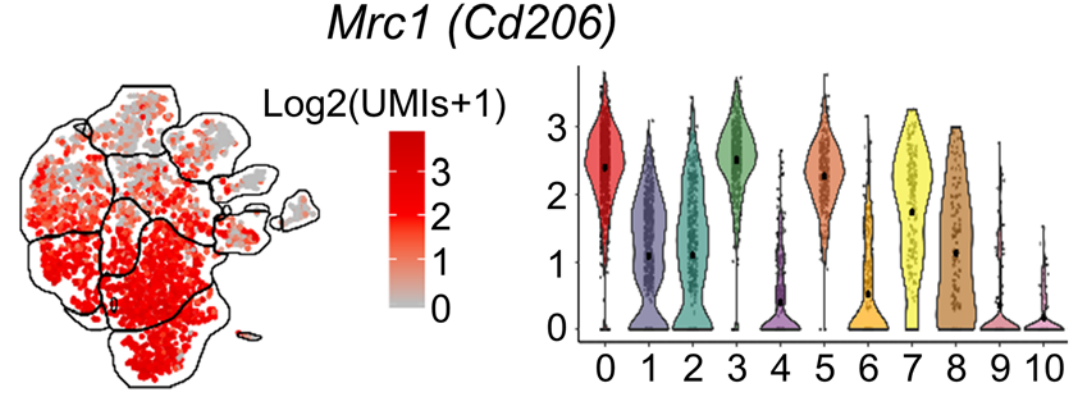

In [41]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Mrc1", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Mrc1"], groupby='clusters')
Image(filename='Mrc1.png')

*Mrc1* is highly expressed in clusters 0,4,5 and 7. It suggests that those clusters can be resident adventitial macrophages.

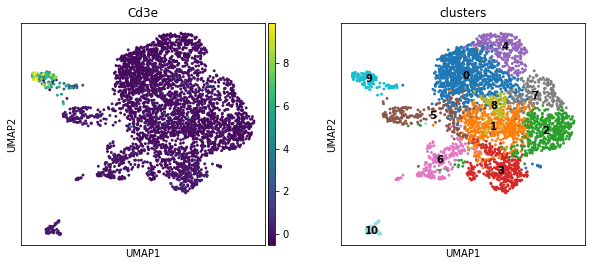

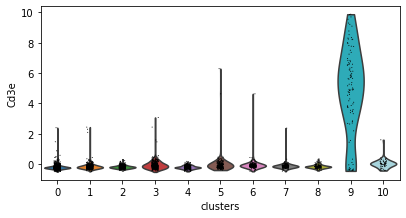

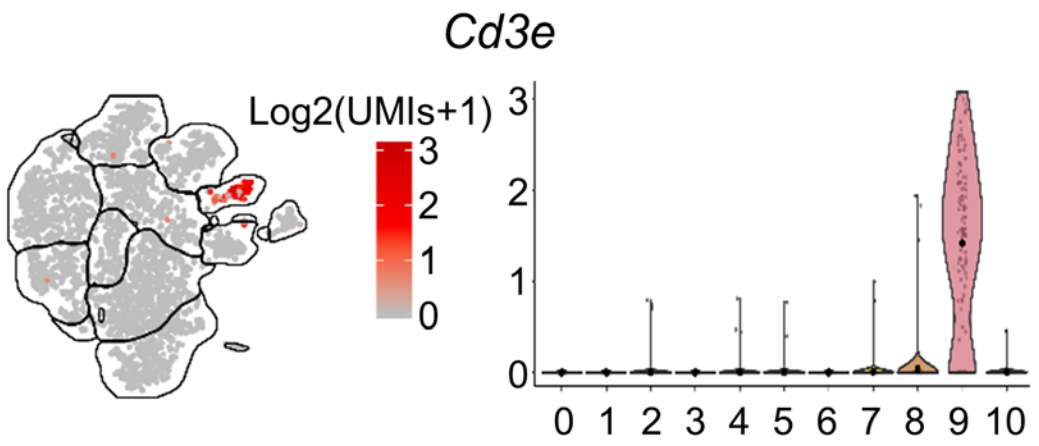

In [42]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Cd3e", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Cd3e"], groupby='clusters')
Image(filename='Cd3e.png')

Cluster 9 had a high expression of *Cd3e*, which is coding a T-cell receptor.

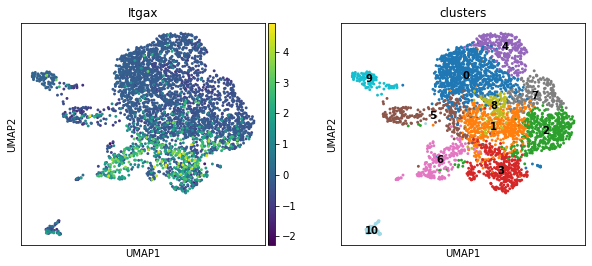

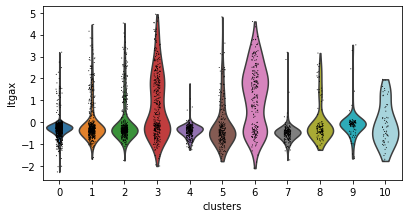

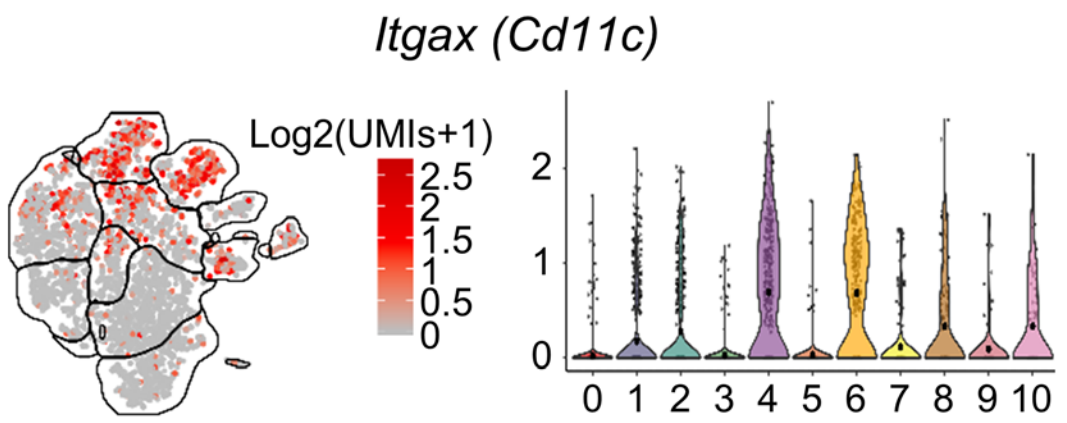

In [43]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Itgax", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Itgax"], groupby='clusters')
Image(filename='Itgax.png')

*Itgax* is highly expressed in clusters 3 and 6, which corresponds to the publication.

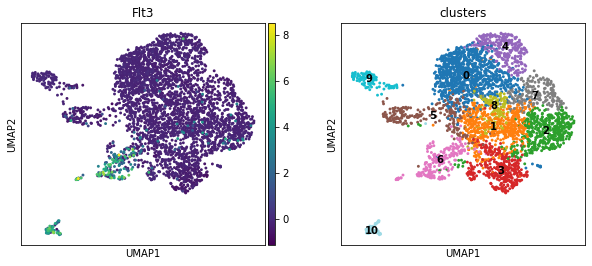

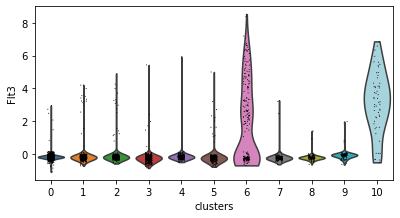

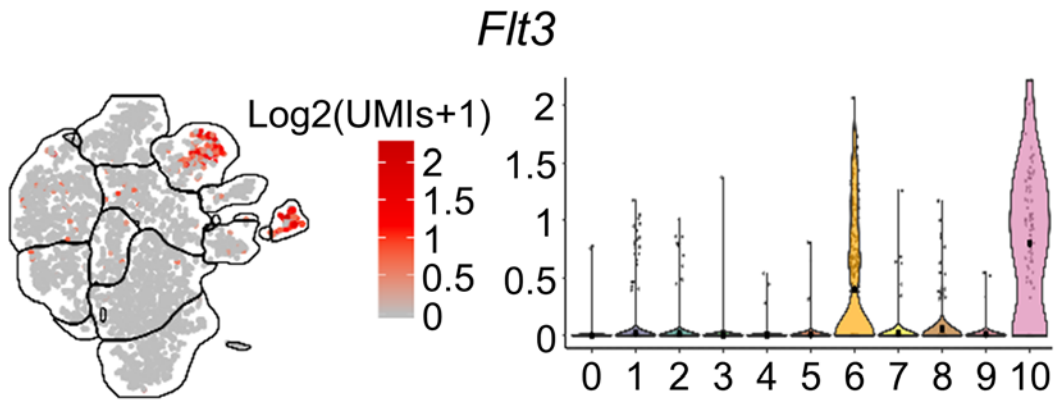

In [44]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Flt3", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Flt3"], groupby='clusters')
Image(filename='Flt3.png')

Clusters 6 and 10 showed high-level expression of *Flt3* gene, which is required for dendritic cells differentiation.

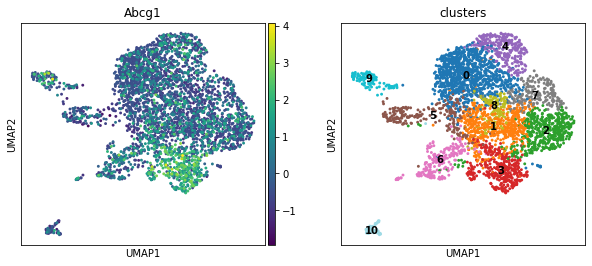

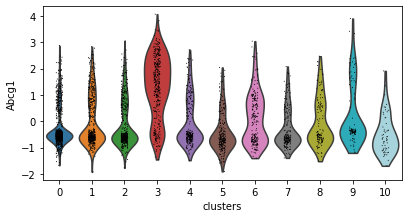

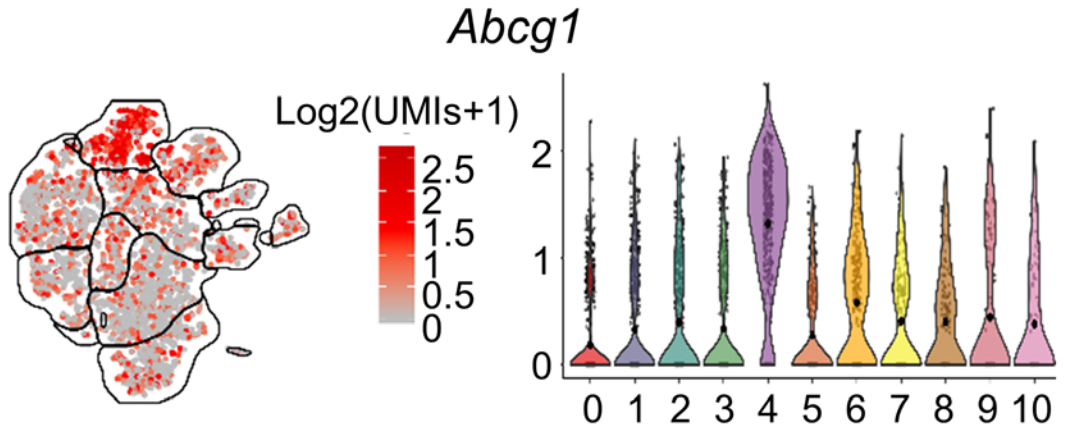

In [45]:
with rc_context({'figure.figsize': (4.3, 4)}):
    sc.pl.umap(adata, color=["Abcg1", "clusters"],  legend_loc='on data')
with rc_context({'figure.figsize': (6, 3.3)}):
    sc.pl.violin(adata, ["Abcg1"], groupby='clusters')
Image(filename='Abcg1.png')

Expression of *Abcg1* gene corresponds to the publication.

Now let's look at the heatmap.

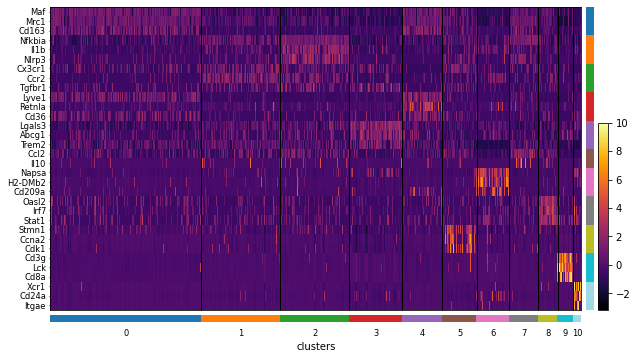

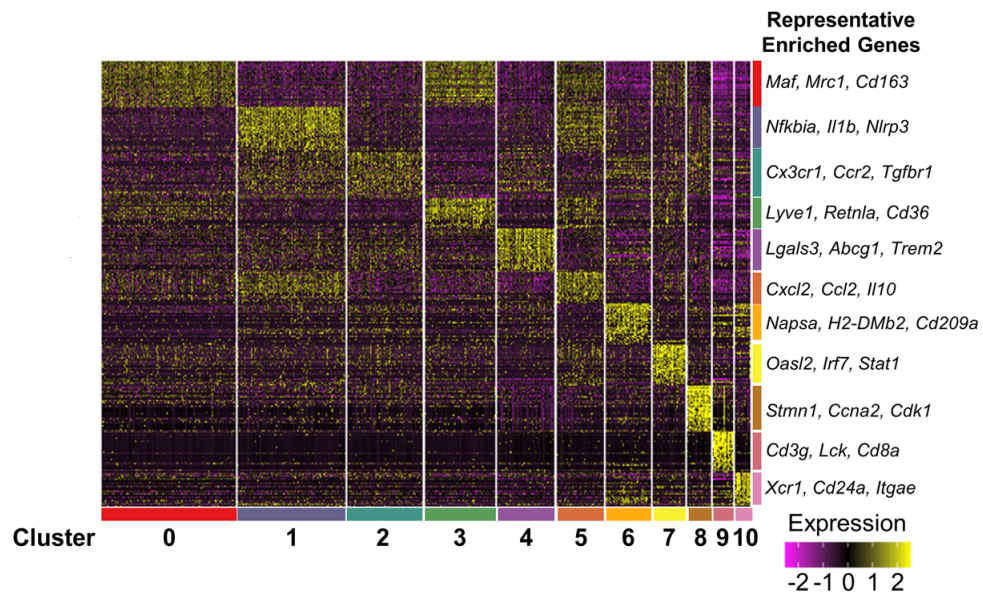

In [56]:
marker_genes_dict = {
    'Maf, Mrc1, Cd163': ["Maf", "Mrc1", "Cd163"],
    'Nfkbia, Il1b, Nlrp3': ["Nfkbia", "Il1b", "Nlrp3"],
    'Cx3cr1, Ccr2, Tgfbr1': ["Cx3cr1", "Ccr2", "Tgfbr1"],
    'Lyve1, Retnl", Cd36': ["Lyve1", "Retnla", "Cd36"],
    'Lgals3, Abcg1, Trem2': ["Lgals3", "Abcg1", "Trem2"],
    'Ccl2, Il10': ["Ccl2", "Il10"],
    'Napsa, H2-DMb2, Cd209a': ["Napsa", "H2-DMb2", "Cd209a"],
    'Oasl2, Irf7, Stat1': ["Oasl2", "Irf7", "Stat1"],
    'Stmn1, Ccna2, Cdk1': ["Stmn1", "Ccna2", "Cdk1"],
    'Cd3g, Lck, Cd8a': ["Cd3g", "Lck", "Cd8a"],
    'Xcr1, Cd24a, Itgae': ["Xcr1", "Cd24a", "Itgae"],
}
ax = sc.pl.heatmap(adata, marker_genes_dict, groupby='clusters', cmap='inferno',swap_axes = True)
Image(filename='heatmap.png')

**Conclusion**: Upon comparison with the related publication we can conclude that the results are very similar to the corresponding plots, except the order of the cluster (e.g. clusters 3 and 4 are seemed to be swapped). This can be attributed to the different number of PCs used for detecting neighbours and other parameters used in the analysis.